Process raw Infinium 850k methylation array raw data using meffil R package: https://github.com/perishky/meffil/wiki/
- This notebooks performs functional normalisation
- add tissue type from excel
- Date: 27.10.25

### Setup

In [1]:
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          5.1                         
year           2025                        
month          06                          
day            13                          
svn rev        88306                       
language       R                           
version.string R version 4.5.1 (2025-06-13)
nickname       Great Square Root           

In [2]:
## load libraries
library(stringr)
library(data.table) 
library(vroom)
library(ggplot2)
library(tidyr)
library(limma)
library(meffil)
library(readxl)
library(dplyr)


Loading required package: illuminaio

Loading required package: MASS

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: sva

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following object is masked from ‘package:MASS’:

    area


The following object is masked from ‘package:vroom’:

    spec


Loading required package: BiocParallel

Loading required package: plyr

Loading required package: reshape2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


The following objects are masked from ‘package:data.table’:

  

In [3]:
packageVersion("meffil")

[1] ‘1.5.1’

In [4]:
# set wd
setwd('/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/')

In [5]:
# set # of cores
library(parallel)
cores = detectCores()
cores
options(mc.cores=cores)

[1] 40

In [7]:
# generate sample sheet
samplesheet <- meffil.create.samplesheet('BrainSamples/data//idats_140716', recursive=TRUE)
# update sex and Sample name
batch <- fread('metadata/pheno.csv')

upd <- 
fread('BrainSamples/data/idats_140716/Samples_Table_140716.csv') %>% 
    mutate(Sample_Name = paste0(`Sentrix Barcode`, "_", `Array`)) %>%
    dplyr::select(c('Sample ID', 'Sample_Name')) %>%
    dplyr::rename('Sample_Name2' = 'Sample ID')

samplesheet <-
inner_join(samplesheet, upd, by = 'Sample_Name') %>% 
    dplyr::mutate(Sample_Name = Sample_Name2) %>%
    dplyr::select(-c(Sample_Name2)) %>%
    dplyr::select(-c(Sex)) %>%
    left_join(., batch, by = c('Sample_Name'='sample.ID')) %>%
    dplyr::rename('Sex' = 'sex')
samplesheet %>% head
samplesheet %>% dim

,Sample_Name,Slide,sentrix_row,sentrix_col,Basename,Sex,age,batch,tissue.region,PH,PMI,sample.wait.time,np.dignosis,cause.of.death
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>
1,SD001/11B,200514040135,01,01,BrainSamples/data//idats_140716/200514040135_R01C01,M,74,2056G,Cortex,6.30,46,5,No significant abnormalities,1a) Pulmonary thrombo-embolism 1b) Deep vein thrombosis
2,SD033/10,200514040135,02,01,BrainSamples/data//idats_140716/200514040135_R02C01,M,51,2056G,Cortex,6.30,52,0,No significant abnormalities,1a) Ischaemic and hypertensive heart disease
3,SD024/08,200514040135,03,01,BrainSamples/data//idats_140716/200514040135_R03C01,M,39,2056G,Cortex,6.00,42,5,No significant abnormalities,1a) Ischaemic heart disease 1b) Coronary artery atherosclerosis
4,SD039/08,200514040135,04,01,BrainSamples/data//idats_140716/200514040135_R04C01,M,41,2056G,Cortex,6.40,41,5,No significant abnormalities,1a) External asphyxia by inhalation of helium
5,SD043/06,200514040135,05,01,BrainSamples/data//idats_140716/200514040135_R05C01,F,53,2056G,Cortex,6.38,42,5,No significant abnormalities,1a) Ischaemic heart disease 1b) Severe coronary artery atheroma 1c) Atherosclerosis 2. Chronic obstructive pulmonary disease
6,SD034/09B,200514040135,06,01,BrainSamples/data//idats_140716/200514040135_R06C01,M,49,2056G,Cortex,6.23,79,0,"Vascular disease, other",1a) ischaemic and hypertensive heart disease


[1] 136  14

In [8]:
### load QC objects
load("meffil_data/qc.objects.clean.Robj")
length(qc.objects)
load("meffil_data/qcsummary.clean.Robj")

[1] 126

### Estimate number of PCs to use

Next we need to estimate how many principal components (PCs) to use to adjust the methylation levels for technical effects. We can use 10-fold cross validation to estimate the residual variance after fitting n number of PCs. The residuals should consistently decrease with increasing numbers of PCs. The plot generated is similar to an elbow curve. The idea is to choose the number of PCs at which the residuals decreases abruptly. Sometimes there is more than one elbow and I would choose the one with the highest number of PCs. For ARIES there was a dramatic drop around 10 PCs.

In [9]:
y <- meffil.plot.pc.fit(qc.objects)
ggsave(y$plot, filename="meffil_data/pc.fit.pdf", height=6, width=6)

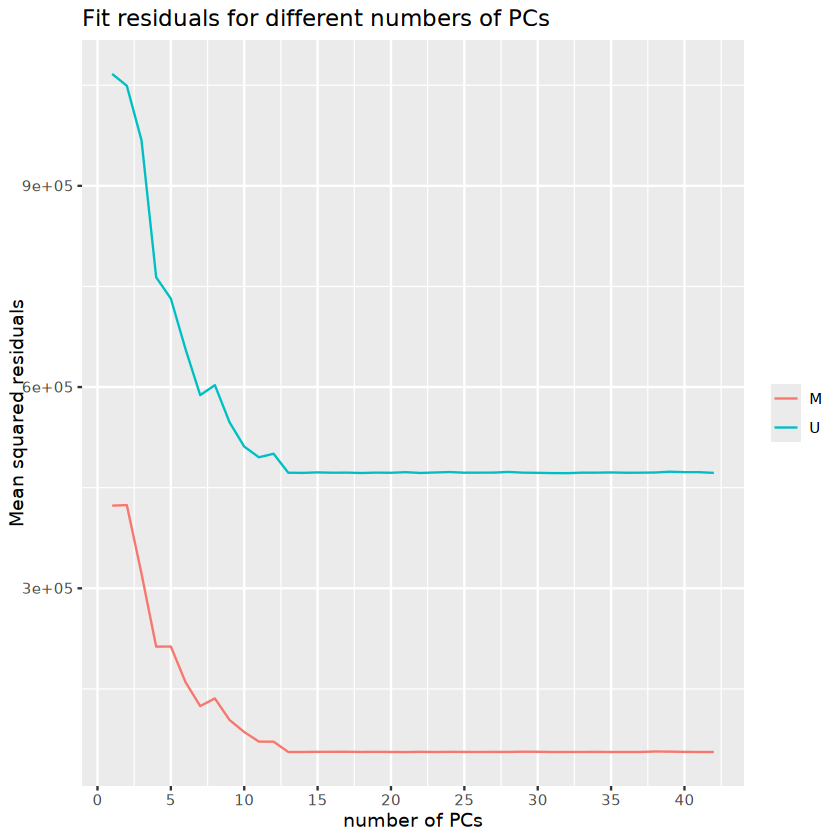

In [10]:
## set number of PCs to use
y$plot
pc <- 10 # 10 is good

### Perform functional normalisation

In [12]:
qc.summary$bad.cpgs$name %>% length

[1] 1008

In [16]:
pc=10
norm.objects <- meffil.normalize.quantiles(qc.objects, number.pcs=pc)
save(norm.objects,file=paste("meffil_data/norm.obj.pc", pc, ".Robj", sep=""))

norm.beta <- meffil.normalize.samples(norm.objects, cpglist.remove=qc.summary$bad.cpgs$name)
save(norm.beta,file=paste("meffil_data/norm.beta.pc", pc, ".Robj", sep=""))

In [13]:
str(norm.objects[[1]]$samplesheet)

#You change it by running a loop

for (i in 1:length(norm.objects)){
    norm.objects[[i]]$samplesheet$Slide<-as.factor(norm.objects[[i]]$samplesheet$Slide)
    norm.objects[[i]]$samplesheet$Sex<-as.factor(norm.objects[[i]]$samplesheet$Sex)
    norm.objects[[i]]$samplesheet$sentrix_row<-as.factor(norm.objects[[i]]$samplesheet$sentrix_row)
    norm.objects[[i]]$samplesheet$sentrix_col<-as.factor(norm.objects[[i]]$samplesheet$sentrix_col)
    norm.objects[[i]]$samplesheet$batch<-as.factor(norm.objects[[i]]$samplesheet$batch)
    norm.objects[[i]]$samplesheet$tissue.region<-as.factor(norm.objects[[i]]$samplesheet$tissue.region) 	
}

batch_var<-c("Slide", "plate","Sex", "batch", "tissue.region") #PLEASE EDIT THIS LINE
norm.parameters <- meffil.normalization.parameters(
	norm.objects,
	variables=batch_var,
	control.pcs=1:10,
	batch.pcs=1:10,
	batch.threshold=0.01
)

'data.frame':	1 obs. of  9 variables:
 $ Sample_Name     : chr "SD001/11B"
 $ Slide           : chr "200514040135"
 $ sentrix_row     : chr "01"
 $ sentrix_col     : chr "01"
 $ Basename        : chr "BrainSamples/data//idats_140716/200514040135_R01C01"
 $ Sex             : chr "M"
 $ batch           : chr "2056G"
 $ tissue.region   : chr "Cortex"
 $ sample.wait.time: int 5


In [21]:
# get autosomal sites only
meffil.list.featuresets()
featureset<-"epic"
autosomal.sites <- meffil.get.autosomal.sites(featureset)
autosomal.sites <- intersect(autosomal.sites, rownames(norm.beta))
norm.beta <- norm.beta[autosomal.sites,]

[1] "450k"            "common"          "epic"            "epic2"           "mouse"           "450k:epic"       "450k:epic2"      "epic:epic2"      "450k:epic:epic2"

In [56]:
# drop sites with SNPs within CpG interrogation or at the single nucleotide extension, see minfi_00_get_SNP_sites.ipynb
snps.to.drop <- fread('minfi_data/snps.dropped.csv')
cat(length(snps.to.drop$site.name), 'sites to drop')
sites.to.keep <- setdiff(rownames(norm.beta), snps.to.drop$site.name)
norm.beta <- norm.beta[sites.to.keep,]

30435 sites to drop

In [75]:
# check if snps remain
anno <- meffil.get.features("epic")
snps <- anno %>% filter(target == 'snp') %>% pull(name)
intersect(rownames(norm.beta), snps)

character(0)

In [58]:
## principal components for the normalized methylation matrix
pcs <- meffil.methylation.pcs(norm.beta, probe.range=20000, sites=rownames(norm.beta))
save(pcs,file="meffil_data/pcs.norm.beta.Robj")

In [59]:
norm.summary <- meffil.normalization.summary(norm.objects, pcs=pcs, parameters=norm.parameters)
meffil.normalization.report(norm.summary, output.file="meffil_data/normalization-report.html")

[meffil.plot.control.batch] Tue Nov  4 11:38:42 2025 Extracting batch variables 
[meffil.plot.control.batch] Tue Nov  4 11:38:42 2025 Testing associations 
[meffil.plot.probe.batch] Tue Nov  4 11:38:50 2025 Extracting batch variables 
[meffil.plot.probe.batch] Tue Nov  4 11:38:50 2025 Testing associations 
[meffil.normalization.report] Tue Nov  4 11:38:55 2025 Writing report as html file to meffil_data/normalization-report.html 




processing file: /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports/normalization-report.rmd



1/36                   
2/36 [unnamed-chunk-1] 
3/36                   
4/36 [unnamed-chunk-2] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


5/36                   
6/36 [unnamed-chunk-3] 
7/36                   
8/36 [unnamed-chunk-4] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


9/36                   
10/36 [unnamed-chunk-5] 
11/36                   
12/36 [unnamed-chunk-6] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


13/36                   
14/36 [unnamed-chunk-7] 
15/36                   
16/36 [unnamed-chunk-8] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


17/36                   
18/36 [unnamed-chunk-9] 
19/36                   
20/36 [unnamed-chunk-10]
21/36                   
22/36 [unnamed-chunk-11]


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


23/36                   
24/36 [unnamed-chunk-12]
25/36                   
26/36 [unnamed-chunk-13]


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


27/36                   
28/36 [unnamed-chunk-14]
29/36                   
30/36 [unnamed-chunk-15]


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data (probably via setwd()). It will be restored to /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/R-packages/meffil/reports. See the Note section in ?knitr::knit"


31/36                   
32/36 [unnamed-chunk-16]
33/36                   
34/36 [unnamed-chunk-17]
35/36                   
36/36 [unnamed-chunk-18]


output file: /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data/normalization-report.md




[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/EBB_methylation/meffil_data/normalization-report.html"

In [64]:
## save final normalised dataset
dim(norm.beta)
save(norm.beta, file=paste("meffil_data/norm.beta.pc", pc, "clean.Robj", sep=""))

[1] 815429    126

### Extract cell counts

see: https://github.com/perishky/meffil/wiki/Estimating-cellular-composition: 
- `"guintivano dlpfc"` Recreates cell type reference from bioconductor package FlowSorted.DLPFC.450k. Differentiates between neurons and other cell types.

In [60]:
cc<-t(sapply(qc.objects, function(obj) obj$cell.counts$counts))
cc<-data.frame(IID=row.names(cc),cc)
write.table(cc,"meffil_data/cellcounts.txt",sep="\t",row.names=F,col.names=T,quote=F)

,IID,NeuN_neg,NeuN_pos
,<chr>,<dbl>,<dbl>
SD001/11B,SD001/11B,0.6285918,0.4625232
SD033/10,SD033/10,0.8372315,0.2716126
SD024/08,SD024/08,0.6106466,0.5192592
SD039/08,SD039/08,0.6085947,0.5233581
SD043/06,SD043/06,0.6262353,0.5026038
SD034/09B,SD034/09B,0.7602542,0.3606747


[1] 126   3

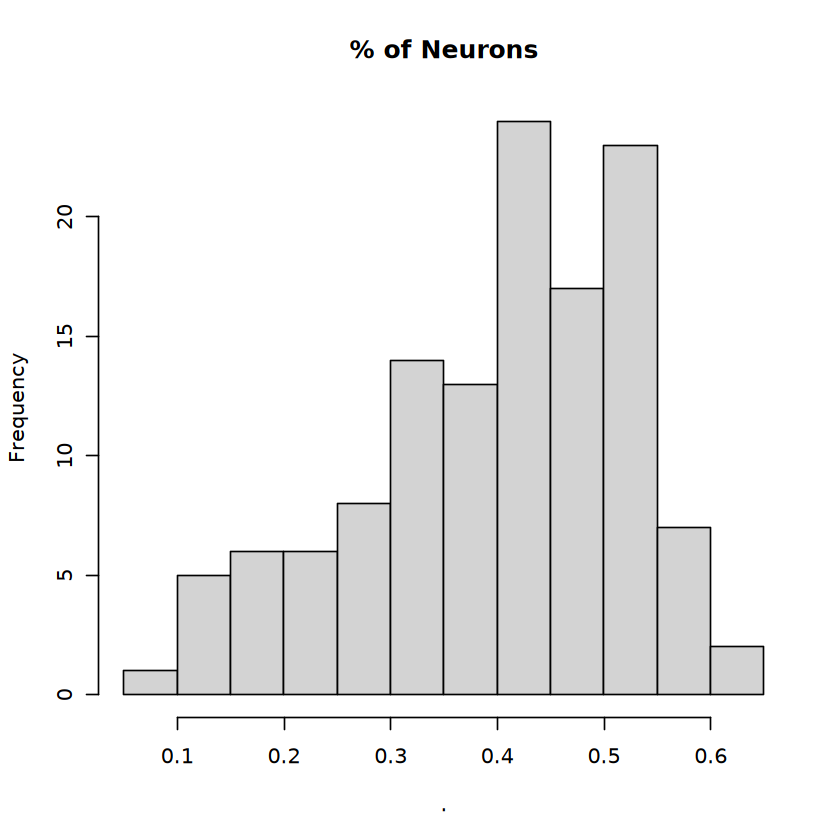

In [72]:
cc %>% head
cc %>% dim
cc$NeuN_pos %>% hist(., main = '% of Neurons')

In [62]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: x86_64-conda-linux-gnu
Running under: Rocky Linux 9.5 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/jupiter-setup/envs/jpt/lib/libopenblasp-r0.3.26.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8    LC_PAPER=en_US.UTF-8      
 [8] LC_NAME=C                  LC_ADDRESS=C               LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] minfi_1.54.1                bumphunter_1.50.0           locfit_1.5-9.12             iterators_1.0.14            foreach_1.5.2               Biostrings_2.76.0           XVe